In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('./base_limpa/base_unificada_limpa_remocao.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199444 entries, 0 to 199443
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_obito             199444 non-null  object 
 1   ano_obito              199444 non-null  int64  
 2   TIPOBITO               199444 non-null  int64  
 3   ocor_MUNNOMEX          199444 non-null  object 
 4   res_MUNNOMEX           199444 non-null  object 
 5   ocor_CAPITAL           199444 non-null  object 
 6   res_CAPITAL            199444 non-null  object 
 7   ocor_REGIAO            199444 non-null  object 
 8   res_REGIAO             199444 non-null  object 
 9   ocor_SIGLA_UF          199444 non-null  object 
 10  res_SIGLA_UF           199444 non-null  object 
 11  IDADEMAE               199444 non-null  float64
 12  idademae_faixa         199444 non-null  object 
 13  ESCMAE2010             199444 non-null  float64
 14  escolaridade_mae       199444 non-nu

O código calcula o risco relativo (RR) de óbito fetal entre diferentes categorias de recém-nascidos e gera um gráfico de erro para visualização. Ele faz isso comparando a frequência de óbitos em diferentes grupos definidos por idade gestacional (termo ou pré-termo) e adequação ao peso gestacional (AIG, PIG, GIG).

1. Cálculo do Risco Relativo (RR)
O risco relativo (RR) é uma medida de associação usada em epidemiologia para comparar a probabilidade de um evento entre dois grupos. No caso, queremos comparar o risco de óbito fetal entre diferentes grupos de recém-nascidos.

**RR = Número de óbitos no grupo exposto / Número de óbitos no grupo de referência**

Ou seja, se houver 100 óbitos em bebês pré-termo pequenos para idade gestacional (Pre_Termo_PIG) e 50 óbitos em bebês termo adequados para idade gestacional (Termo_AIG) o RR = 100/50 = 2, isso significa que o risco de óbito fetal no grupo Pre_Termo_PIG é duas vezes maior que no grupo Termo_AIG.

2. Intervalo de Confiança para o Risco Relativo
O código calcula um intervalo de confiança de 95% para o RR, utilizando a seguinte fórmula baseada no logaritmo do RR:

![ic.png](ic.png)

Onde:

* E é o número de óbitos no grupo exposto.
* R é o número de óbitos no grupo de referência.
* O fator 1.96 corresponde ao quantil da distribuição normal para um intervalo de confiança de 95%.

Isso ajuda a verificar se o RR é estatisticamente significativo (se o IC não inclui 1, a diferença entre os grupos é significativa).

In [21]:
def calculate_rr(df, region=None):
    if region:
        df = df[df['ocor_REGIAO'] == region].reset_index(drop=True)
    
    df['group'] = 'Termo_AIG'
    df.loc[(df['cat_periodo_nasc'] == 'termo') & (df['cat_peso_calc'] == 'PIG'), 'group'] = 'Termo_PIG'
    df.loc[(df['cat_periodo_nasc'] == 'pre_termo') & (df['cat_peso_calc'] == 'AIG'), 'group'] = 'Pre_Termo_AIG'
    df.loc[(df['cat_periodo_nasc'] == 'pre_termo') & (df['cat_peso_calc'] == 'PIG'), 'group'] = 'Pre_Termo_PIG'
    df.loc[(df['cat_periodo_nasc'] == 'termo') & (df['cat_peso_calc'] == 'GIG'), 'group'] = 'Termo_GIG'
    df.loc[(df['cat_periodo_nasc'] == 'pre_termo') & (df['cat_peso_calc'] == 'GIG'), 'group'] = 'Pre_Termo_GIG'
    
    total_deaths = df['group'].value_counts()
    rr_results = []
    comparisons = [
        ('Termo_AIG', 'Termo_PIG'),
        ('Termo_AIG', 'Pre_Termo_AIG'),
        ('Termo_AIG', 'Pre_Termo_PIG'),
        ('Termo_AIG', 'Termo_GIG'),
        ('Termo_AIG', 'Pre_Termo_GIG')
    ]
    
    for ref, exp in comparisons:
        if ref in total_deaths and exp in total_deaths:
            rr = total_deaths[exp] / total_deaths[ref]
            ci_lower = rr * np.exp(-1.96 * np.sqrt(1/total_deaths[exp] + 1/total_deaths[ref]))
            ci_upper = rr * np.exp(1.96 * np.sqrt(1/total_deaths[exp] + 1/total_deaths[ref]))
            rr_results.append({
                'Region': region if region else 'Brasil',
                'Comparison': f'{exp} vs {ref}',
                'RR': round(rr, 2),
                'CI Lower': round(ci_lower, 2),
                'CI Upper': round(ci_upper, 2)
            })
    
    return pd.DataFrame(rr_results)


 interpretação dos resultados:

Termo_PIG vs Termo_AIG (RR = 0.85, IC: 0.84 – 0.87)

Bebês termo pequenos para idade gestacional (Termo_PIG) têm um risco de óbito 15% menor em comparação com os bebês termo adequados para idade gestacional (Termo_AIG).
Como o intervalo de confiança está completamente abaixo de 1, essa diferença é estatisticamente significativa.
Pre_Termo_AIG vs Termo_AIG (RR = 2.12, IC: 2.09 – 2.16)

Bebês pré-termo e adequados para idade gestacional (Pre_Termo_AIG) apresentam um risco 2,12 vezes maior de óbito fetal do que bebês termo adequados para idade gestacional.
O IC indica alta precisão da estimativa, reforçando a robustez do resultado.
Pre_Termo_PIG vs Termo_AIG (RR = 2.74, IC: 2.70 – 2.78)

O grupo de bebês pré-termo e pequenos para idade gestacional (Pre_Termo_PIG) tem um risco de óbito 2,74 vezes maior que o grupo Termo_AIG.
Esse é o maior RR da tabela, sugerindo que a combinação de prematuridade e restrição de crescimento intrauterino aumenta consideravelmente o risco de óbito fetal.
Termo_GIG vs Termo_AIG (RR = 0.28, IC: 0.27 – 0.28)

Bebês termo e grandes para idade gestacional (Termo_GIG) apresentam um risco de óbito 72% menor em comparação com bebês Termo_AIG.
O IC é estreito, indicando alta precisão na estimativa.
Pre_Termo_GIG vs Termo_AIG (RR = 1.08, IC: 1.06 – 1.10)

Bebês pré-termo e grandes para idade gestacional (Pre_Termo_GIG) têm um risco de óbito apenas 8% maior que os Termo_AIG.
Apesar do aumento no risco, esse RR é bem menor comparado ao de outros grupos de pré-termos, sugerindo que o crescimento fetal compensado pode reduzir parte do impacto negativo da prematuridade.

Apesar do aumento no risco, esse RR é bem menor comparado ao de outros grupos de pré-termos, sugerindo que o crescimento fetal compensado pode reduzir parte do impacto negativo da prematuridade.


**Conclusão**

* Prematuridade é o maior fator de risco para óbito fetal. Tanto os bebês pré-termo adequados (RR = 2.12) quanto os pré-termo pequenos (RR = 2.74) têm risco significativamente maior de morte em relação aos bebês termo adequados.
* Restrição de crescimento intrauterino (PIG) também impacta a mortalidade, mas em menor grau quando o bebê nasce a termo. Bebês termo pequenos (RR = 0.85) têm risco reduzido, enquanto os pré-termo pequenos (RR = 2.74) têm risco muito elevado.
* Bebês grandes para idade gestacional (GIG) apresentam menor risco de óbito. Tanto os termo GIG (RR = 0.28) quanto os pré-termo GIG (RR = 1.08) têm menores taxas de mortalidade comparadas a outros grupos.
* Esse padrão sugere que a prematuridade combinada com restrição de crescimento intrauterino é a pior condição para a sobrevivência fetal, enquanto o crescimento fetal excessivo pode ter um efeito protetor.

In [22]:
df_brasil = calculate_rr(df)
# Exibindo os resultados
display(df_brasil)

,Region,Comparison,RR,CI Lower,CI Upper
0,Brasil,Termo_PIG vs Termo_AIG,0.85,0.84,0.87
1,Brasil,Pre_Termo_AIG vs Termo_AIG,2.12,2.09,2.16
2,Brasil,Pre_Termo_PIG vs Termo_AIG,2.74,2.70,2.78
3,Brasil,Termo_GIG vs Termo_AIG,0.28,0.27,0.28
4,Brasil,Pre_Termo_GIG vs Termo_AIG,1.08,1.06,1.10


1. Comparação entre Regiões para cada Grupo

**Bebês Termo Pequenos para Idade Gestacional (Termo_PIG) vs Termo_AIG**
* O Sul apresenta o menor RR (0.75), indicando que bebês Termo_PIG têm 25% menos risco de óbito em comparação com Termo_AIG.
* O Norte tem o maior RR (0.82), sugerindo um risco um pouco maior de óbito para bebês Termo_PIG nessa região.
* No geral, todas as regiões indicam um efeito protetor para bebês Termo_PIG, mas com diferenças regionais.

**Bebês Pré-Termo Adequados para Idade Gestacional (Pre_Termo_AIG) vs Termo_AIG**
* O Nordeste tem o menor RR (1.74), indicando que bebês Pre_Termo_AIG têm 74% mais risco de óbito em relação aos Termo_AIG.
* O Sudeste tem o maior RR (2.66), sugerindo um risco significativamente maior de óbito fetal para bebês Pre_Termo_AIG nessa região.
* O Sul e Centro-Oeste também apresentam RR elevados (2.33 e 2.32), sugerindo que a prematuridade tem maior impacto nessas regiões.

**Bebês Pré-Termo Pequenos para Idade Gestacional (Pre_Termo_PIG) vs Termo_AIG**
* O Norte tem o menor RR (1.82), sugerindo um aumento de 82% no risco de óbito para bebês Pre_Termo_PIG em relação a Termo_AIG.
* O Sudeste apresenta o maior RR (3.64), o que significa um risco 3,64 vezes maior de óbito nessa categoria.
* Sul e Centro-Oeste também apresentam valores elevados, destacando a combinação entre prematuridade e restrição de crescimento intrauterino como um fator de risco crítico.

**Bebês Termo Grandes para Idade Gestacional (Termo_GIG) vs Termo_AIG**
* O Sul tem o menor RR (0.22), indicando um risco 78% menor de óbito fetal para bebês Termo_GIG comparado a Termo_AIG.
* O Nordeste tem um RR um pouco maior (0.31), mas ainda indicando um efeito protetor para bebês Termo_GIG.
* Em todas as regiões, o RR está abaixo de 1, indicando menor risco de óbito para bebês grandes para a idade gestacional.

**Bebês Pré-Termo Grandes para Idade Gestacional (Pre_Termo_GIG) vs Termo_AIG**
* O Nordeste apresenta o menor RR (0.93), sugerindo risco similar entre Pre_Termo_GIG e Termo_AIG.
* O Sudeste tem o maior RR (1.23), indicando um risco 23% maior de óbito fetal para bebês Pre_Termo_GIG.
* O Centro-Oeste (1.18) e Norte (1.12) mostram um risco ligeiramente aumentado.

2. Principais Tendências Regionais

* Maior risco de óbito para prematuros no Sudeste

* O Sudeste tem os maiores RRs para Pre_Termo_AIG (2.66) e Pre_Termo_PIG (3.64), indicando que a prematuridade e a restrição de crescimento intrauterino são fatores críticos para a mortalidade nessa região.

*Menor risco para Termo_GIG no Sul

* O Sul apresenta o menor RR (0.22) para bebês Termo_GIG, sugerindo que bebês grandes para idade gestacional nessa região têm a melhor sobrevivência.

* O Norte apresenta menor impacto da prematuridade extrema

* O Pre_Termo_PIG vs Termo_AIG no Norte tem um RR de 1.82, o menor entre as regiões, indicando um impacto menor da prematuridade severa em relação a outras regiões.

* O Nordeste tem menor risco para Pre_Termo_GIG

* O Nordeste é a única região onde Pre_Termo_GIG tem um RR abaixo de 1 (0.93), sugerindo que nessa região, o crescimento fetal excessivo pode compensar parte do risco da prematuridade.

**Conclusão**

* A prematuridade combinada com restrição de crescimento representa o maior risco de óbito, especialmente no Sudeste.

* Bebês termo grandes para idade gestacional (GIG) têm menor risco de óbito, principalmente no Sul.

In [23]:
df_regioes = pd.concat([calculate_rr(df, region) for region in df['ocor_REGIAO'].unique()])
display(df_regioes)

,Region,Comparison,RR,CI Lower,CI Upper
0,Norte,Termo_PIG vs Termo_AIG,0.82,0.78,0.86
1,Norte,Pre_Termo_AIG vs Termo_AIG,1.76,1.68,1.83
2,Norte,Pre_Termo_PIG vs Termo_AIG,1.82,1.75,1.90
3,Norte,Termo_GIG vs Termo_AIG,0.30,0.28,0.32
4,Norte,Pre_Termo_GIG vs Termo_AIG,1.12,1.07,1.17
0,Nordeste,Termo_PIG vs Termo_AIG,0.87,0.85,0.90
1,Nordeste,Pre_Termo_AIG vs Termo_AIG,1.74,1.69,1.78
2,Nordeste,Pre_Termo_PIG vs Termo_AIG,2.22,2.17,2.28
3,Nordeste,Termo_GIG vs Termo_AIG,0.31,0.29,0.32
4,Nordeste,Pre_Termo_GIG vs Termo_AIG,0.93,0.90,0.96


In [19]:
df_brasil.to_csv('resultado/rr_obitos_brasil.csv', index=False)
df_regioes.to_csv('resultado/rr_obitos_regiao.csv', index=False)

<ipython-input-20-554429fbaf07>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_brasil['Comparison'], rotation=45, ha='right')


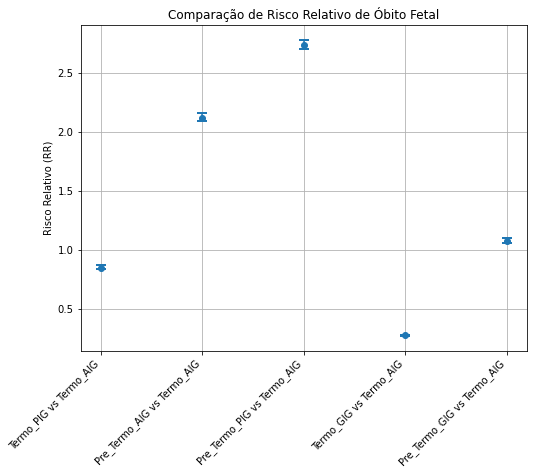

In [20]:
# Criando o gráfico
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(df_brasil['Comparison'], df_brasil['RR'], 
            yerr=[df_brasil['RR'] - df_brasil['CI Lower'], df_brasil['CI Upper'] - df_brasil['RR']], 
            fmt='o', capsize=5, capthick=2)
ax.set_xticklabels(df_brasil['Comparison'], rotation=45, ha='right')
ax.set_ylabel('Risco Relativo (RR)')
ax.set_title('Comparação de Risco Relativo de Óbito Fetal')
plt.grid()
plt.show()